In [5]:
# Data-handling imports
import numpy as np
import pandas as pd
import eda

# Modeling imports
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Plotting imports
import matplotlib.pyplot as plt
from IPython.display import Markdown
plt.style.use("alex")

# GIS imports
import shapefile as shp
from pyproj import Transformer
import pycrs
from shapely.geometry import Point, Polygon
from shapely.ops import cascaded_union

# SVG imports
import xml.etree.ElementTree as ET
ET.register_namespace("", "http://www.w3.org/2000/svg")
from io import BytesIO

seed = 5777

# Read in & clean data

## Tree data

In [6]:
trees = pd.read_csv("/home/alex/Data/Trees/ENVIRONMENTAL_StreetTrees.csv",
                   parse_dates=[
                       "modified",
                       "PlantDate",
                       "RemovalDat",
                       "created_us",
                       "created_da",
                       "last_edi_1",
                   ])

# Include only extant trees
trees = trees[trees["SiteType"] == "Tree"]

# Typos
trees["Genus"] = trees["Genus"].replace("Planatus", "Platanus")
trees["Genus"] = trees["Genus"].replace("Styphnoloblum", "Styphnolobium")

zelkova = trees["Genus"] == "Zelkova serrata"
trees.loc[zelkova, "Genus"] = "Zelkova"
trees.loc[zelkova, "species"] = "serrata"

# Clean species name
trees["species"] = trees["species"].str.lower()\
    .str.replace("^[a-z]\. ", "")\
    .str.replace(" l\.?$", "")\
    .str.replace("^x ", "× ")\
    .str.replace(" x ", "× ")\
    .fillna("(unknown species)")

# Combine
trees["Sci"] = trees["Genus"] + " " + trees["species"]

# Probably no trees > 6' in diameter. This will make maps nicer
trees["diameter"] = np.minimum(trees["diameter"], 72)

# Extract coordinates
latlon = trees["the_geom"].str.extract("POINT \((?P<lon>[0-9.-]+) (?P<lat>[0-9.-]+)\)").astype(float)
trees = pd.concat([trees, latlon], axis=1)

/home/alex/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (7,30,36,38,39,42,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Invasives data

In [7]:
# Merge with invasiveness data (source: https://www.mass.gov/doc/prohibited-plant-list-sorted-by-scientific-name/download)
invasive_species = pd.read_csv("prohibited-species.txt")
invasive_species["Invasive"] = True

trees = pd.merge(
    left = trees,
    right = invasive_species,
    how = "left",
    on = ["Genus", "species"]
)

trees["Invasive"].fillna(False, inplace=True)

## Neighborhood data

In [8]:
neigh_names = {
   -1: "(unknown)",
    0: "The Port",
    1: "Riverside",
    2: "Neighborhood Nine",
    3: "Area 2/MIT",
    4: "Cambridgeport",
    5: "Mid-Cambridge",
    6: "Wellington-Harrington",
    7: "East Cambridge",
    8: "Agassiz",
    9: "Cambridge Highlands",
    10: "Strawberry Hill",
    11: "West Cambridge",
    12: "North Cambridge",
}

# Read in shapefile
coords = pd.read_csv("NhoodPolygons.csv")["the_geom"].str.extractall("(?P<lon>[0-9.-]+) (?P<lat>[0-9.-]+)").astype(float)

# Convert to polygons
polygons = [Polygon([tuple(point) for (neigh, _), point in coords.iterrows() if neigh == i]) for i in range(13)]

# This returns a list of bools, corresponding to whether the tree is in that neighborhood
neighs = trees[["lon", "lat"]].apply(lambda point: [Point(point).within(polygons[i]) for i in range(len(polygons))], axis=1)

# If not in any neighborhood, assign -1
trees["Neigh"] = list(map(lambda l: np.argmax(l) if sum(l) else -1, neighs))

trees["Neigh_name"] = trees["Neigh"].replace(neigh_names)

In [9]:
display(Markdown(trees.data_dictionary()))

/home/alex/bin/python/eda/report/report.py:62: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(series)
/home/alex/bin/python/eda/report/report.py:63: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(series)


Data frame, 29,387 rows with 784,724 missing values:

| Column       | Type                  | Missing values | Range              | Distribution | Description |
|--------------|-----------------------|----------------|--------------------|--------------|-------------|
| `trunks`     | `int64`               | 0 (0%)         | 0 – 11             | █▁▁▁▁▁▁▁▁▁   |             |
| `the_geom`   | `object`              | 0 (0%)         |                    |              |             |
| `SiteType`   | `object`              | 0 (0%)         |                    |              |             |
| `modified`   | `datetime64[ns, UTC]` | 12,884 (44%)   |                    |              |             |
| `PlantDate`  | `datetime64[ns, UTC]` | 24,510 (83%)   |                    |              |             |
| `RemovalDat` | `datetime64[ns, UTC]` | 29,257 (100%)  |                    |              |             |
| `SpeciesSho` | `object`              | 3,046 (10%)    |                    |              |             |
| `TreeCondit` | `object`              | 18,545 (63%)   |                    |              |             |
| `OverheadWi` | `int64`               | 0 (0%)         | 0 – 1              | █▂           |             |
| `Cultivar`   | `object`              | 26,838 (91%)   |                    |              |             |
| `GlobalID`   | `object`              | 0 (0%)         |                    |              |             |
| `StreetNumb` | `int64`               | 0 (0%)         | 0 – 2985           | █▁▁▁▁▁▁▁▁▁   |             |
| `StreetName` | `object`              | 9,531 (32%)    |                    |              |             |
| `MemTree`    | `object`              | 14,154 (48%)   |                    |              |             |
| `Location`   | `object`              | 83 (0%)        |                    |              |             |
| `Ownership`  | `object`              | 25 (0%)        |                    |              |             |
| `ADAComplia` | `object`              | 27,990 (95%)   |                    |              |             |
| `TreeGrateA` | `int64`               | 0 (0%)         | 0 – 4              | █▁▁▁▁        |             |
| `BareRoot`   | `object`              | 27,572 (94%)   |                    |              |             |
| `diameter`   | `float64`             | 0 (0%)         | 0 – 72             | █▄▃▂▁▁▁▁▁▁   |             |
| `TreeWellCo` | `object`              | 28,868 (98%)   |                    |              |             |
| `Structural` | `object`              | 27,809 (95%)   |                    |              |             |
| `AbutsOpenA` | `object`              | 21,635 (74%)   |                    |              |             |
| `ExposedRoo` | `object`              | 22,131 (75%)   |                    |              |             |
| `TreeID`     | `int64`               | 0 (0%)         | 1 – 1502382        | █▁▁▁▁▁▁▁▁▁   |             |
| `TreeWellID` | `int64`               | 0 (0%)         | 0 – 1501810        | █▁▁▁▁▁▁▁▁▁   |             |
| `created_us` | `object`              | 26,520 (90%)   |                    |              |             |
| `created_da` | `datetime64[ns, UTC]` | 179 (1%)       |                    |              |             |
| `last_edite` | `object`              | 0 (0%)         |                    |              |             |
| `last_edi_1` | `datetime64[ns, UTC]` | 0 (0%)         |                    |              |             |
| `xCartegrap` | `object`              | 5,384 (18%)    |                    |              |             |
| `CommonName` | `object`              | 2,762 (9%)     |                    |              |             |
| `Genus`      | `object`              | 2,765 (9%)     |                    |              |             |
| `Cartegraph` | `object`              | 29,374 (100%)  |                    |              |             |
| `Cartegra_1` | `object`              | 24,559 (84%)   |                    |              |             |
| `Neighborho` | `float64`             | 29,387 (100%)  | nan – nan          |              |             |
| `xspecies_o` | `object`              | 5,297 (18%)    |                    |              |             |
| `Scientific` | `object`              | 2,660 (9%)     |                    |              |             |
| `creator`    | `object`              | 3,455 (12%)    |                    |              |             |
| `inspectr`   | `object`              | 8,775 (30%)    |                    |              |             |
| `species`    | `object`              | 0 (0%)         |                    |              |             |
| `Order_`     | `object`              | 11,044 (38%)   |                    |              |             |
| `PlantingCo` | `object`              | 28,521 (97%)   |                    |              |             |
| `SourceNurs` | `float64`             | 29,387 (100%)  | nan – nan          |              |             |
| `WateringRe` | `object`              | 27,056 (92%)   |                    |              |             |
| `notes`      | `object`              | 16,951 (58%)   |                    |              |             |
| `LocationRe` | `object`              | 29,367 (100%)  |                    |              |             |
| `SiteReplan` | `object`              | 29,367 (100%)  |                    |              |             |
| `SiteRetire` | `object`              | 29,384 (100%)  |                    |              |             |
| `Biochar_Ad` | `object`              | 28,537 (97%)   |                    |              |             |
| `SolarRatin` | `int64`               | 0 (0%)         | 0 – 10             | ▂▁▁▁▂▂▃▄▅█   |             |
| `PruningZon` | `float64`             | 29,387 (100%)  | nan – nan          |              |             |
| `TreeWellLe` | `float64`             | 0 (0%)         | 0 – 99             | █▁▁▁▁▁▁▁▁▁   |             |
| `TreeWellWi` | `float64`             | 0 (0%)         | 0 – 99             | █▁▁▁▁▁▁▁▁▁   |             |
| `TreeWellDe` | `float64`             | 0 (0%)         | 0 – 18             | █▁▁▁▁▁▁      |             |
| `ScheduledR` | `int64`               | 0 (0%)         | 0 – 1              | █▁           |             |
| `RemovalRea` | `object`              | 29,266 (100%)  |                    |              |             |
| `PB`         | `object`              | 29,119 (99%)   |                    |              |             |
| `PlantingSe` | `object`              | 28,578 (97%)   |                    |              |             |
| `Sci`        | `object`              | 2,765 (9%)     |                    |              |             |
| `lon`        | `float64`             | 0 (0%)         | -71.1595 – -71.069 | ▂▃▇▆█▇▅▅▄▂   |             |
| `lat`        | `float64`             | 0 (0%)         | 42.3535 – 42.4035  | ▃▆▆█▆▆▄▃▃▂   |             |
| `Invasive`   | `bool`                | 0 (0%)         | 0 – 1              | █▁           |             |
| `Neigh`      | `int64`               | 0 (0%)         | -1 – 12            | ▂▃▅▆▃▂▆▂▂█   |             |
| `Neigh_name` | `object`              | 0 (0%)         |                    |              |             |


# Varieties

## Map genera

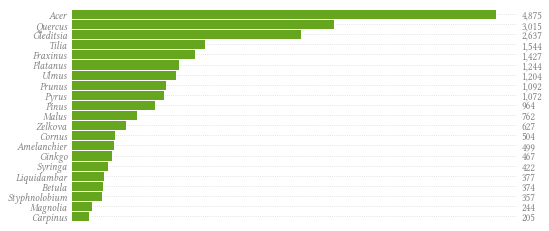

In [25]:
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["font.style"] = "italic"

genera = trees["Genus"].value_counts()[20::-1]

fig, ax = plt.subplots(figsize=(8, 4))
ax = genera.plot.barh(
    ax = ax,
    width = 1,
    color = "C4",
    edgecolor = "white",
    grid = "x",
);
ax.set_axisbelow(True)
ax.set_xticks([])

for i in ax.patches:
    ax.text(
        x = ax.get_xlim()[1] + 50,
        y = i.get_y() + 0.1,
        s = "{:,}".format(i.get_width()),
        color="gray",
        fontdict = {"style": "normal"}
    )
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-genera.svg")

## Map species

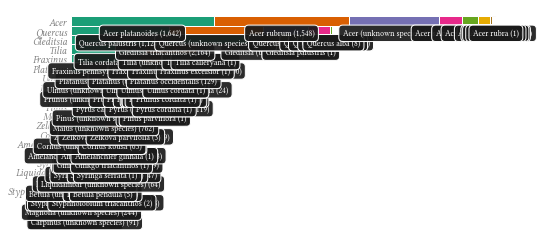

In [24]:
# Tooltip code from <https://matplotlib.org/devdocs/gallery/user_interfaces/svg_tooltip_sgskip.html>

plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "x"

genus_table = trees[trees["Genus"].isin(genera.index)][["Genus", "species"]]
genus_table = pd.crosstab(genus_table["Genus"], genus_table["species"])

bars = []
bar_no = 0

fig, ax = plt.subplots(figsize=(8, 4))
for genus in genera.index:
    sps = genus_table.loc[genus].sort_values(ascending=False)
    sps = sps[sps != 0]
    sps.index = genus + " " + sps.index
    
    left = 0
    for i in range(sps.shape[0]):

        patches = ax.barh(genus, sps[i], left=left, label=genus, edgecolor="w", height=1)
        patch = patches[0]
        patch.set_facecolor(f"C{i % 8}")
        annotate = ax.annotate("{} ({:,})".format(sps.index[i], int(patch.get_width())),
                       xy=(patch.get_x() + patch.get_width()/2, patch.get_y()), xytext=(0, -10),
                       textcoords='offset points', color='w', ha='center',
                       fontsize=8, fontstyle="normal", bbox=dict(boxstyle='round, pad=.5',
                                             fc=(.1, .1, .1, .92),
                                             ec=(1., 1., 1.), lw=1,
                                             zorder=1))

        patch.set_gid('mypatch_{:03d}'.format(bar_no))
        annotate.set_gid('mytooltip_{:03d}'.format(bar_no))
        
        left += sps[i]
        
        bars.append(patch)
        bar_no += 1

ax.set_axisbelow(True)
ax.set_xticks([])

# Save the figure in a fake file object
f = BytesIO()
plt.savefig(f, format="svg")

# --- Add interactivity ---

# Create XML tree from the SVG file.
tree, xmlid = ET.XMLID(f.getvalue())
tree.set('onload', 'init(event)')

for i in bars:
    # Get the index of the shape
    index = bars.index(i)
    # Hide the tooltips
    tooltip = xmlid['mytooltip_{:03d}'.format(index)]
    tooltip.set('visibility', 'hidden')
    # Assign onmouseover and onmouseout callbacks to patches.
    mypatch = xmlid['mypatch_{:03d}'.format(index)]
    mypatch.set('onmouseover', "ShowTooltip(this)")
    mypatch.set('onmouseout', "HideTooltip(this)")

# This is the script defining the ShowTooltip and HideTooltip functions.
script = """
    <script type="text/ecmascript">
    <![CDATA[

    function init(event) {
        if ( window.svgDocument == null ) {
            svgDocument = event.target.ownerDocument;
            }
        }

    function ShowTooltip(obj) {
        var cur = obj.id.split("_")[1];
        var tip = svgDocument.getElementById('mytooltip_' + cur);
        tip.setAttribute('visibility', "visible")
        }

    function HideTooltip(obj) {
        var cur = obj.id.split("_")[1];
        var tip = svgDocument.getElementById('mytooltip_' + cur);
        tip.setAttribute('visibility', "hidden")
        }

    ]]>
    </script>
    """

# Insert the script at the top of the file and save it.
tree.insert(0, ET.XML(script))
ET.ElementTree(tree).write('/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-species.svg')

In [374]:
trees[trees["Genus"] == "Castanea"]

,trunks,the_geom,SiteType,modified,PlantDate,RemovalDat,SpeciesSho,TreeCondit,OverheadWi,Cultivar,...,ScheduledR,RemovalRea,PB,PlantingSe,Sci,lon,lat,Invasive,Neigh,Neigh_name
1727,1,POINT (-71.1398639891527 42.38721567095035),Tree,2011-08-24 00:00:00+00:00,NaT,NaT,Chestnut,NaN,0,NaN,...,0,NaN,NaN,NaN,Castanea (unknown species),-71.139864,42.387216,False,2,Neighborhood Nine
2122,1,POINT (-71.13999321150615 42.39941963148576),Tree,2005-08-31 00:00:00+00:00,NaT,NaT,Chestnut,NaN,0,NaN,...,0,NaN,NaN,NaN,Castanea (unknown species),-71.139993,42.399420,False,12,North Cambridge
9282,1,POINT (-71.14255942217856 42.381902316160044),Tree,2009-11-06 00:00:00+00:00,NaT,NaT,Chestnut,NaN,0,NaN,...,0,NaN,NaN,NaN,Castanea hippocastanum,-71.142559,42.381902,False,11,West Cambridge
10052,1,POINT (-71.14417864896936 42.37697624995451),Tree,2011-08-04 00:00:00+00:00,NaT,NaT,Chestnut,Good,0,NaN,...,0,NaN,NaN,NaN,Castanea (unknown species),-71.144179,42.376976,False,11,West Cambridge


# Geo data

## Read in GIS data

In [7]:
# Convert lat/lon coords to shapefile-compatible coords <https://gis.stackexchange.com/a/135855>
transformer = Transformer.from_crs(
    #pycrs.load.from_file("geo_export_9f844a1e-2539-4cb5-9c73-1c0d50531d5a.prj").to_proj4(),
    "+proj=longlat +a=6378137.0 +rf=298.257223563 +pm=0 +nodef",
    #"EPSG:4326",
    #pycrs.load.from_file("ENVIRONMENTAL_StreetTrees.prj").to_proj4(),
    "+proj=lcc +lat_1=41.71666666666667 +lat_2=42.68333333333333 +lat_0=41 +lon_0=-71.5 +x_0=200000 +y_0=750000.0000000001 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 no_defs"
)

# Read in shapefiles: <https://gis.stackexchange.com/a/309780>

# Cambridge roads <https://www.cambridgema.gov/GIS/gisdatadictionary/Basemap/BASEMAP_Roads>
roads = shp.Reader("BASEMAP_Roads.shp")

# Neighborhoods <https://www.cambridgema.gov/GIS/gisdatadictionary/Boundary/BOUNDARY_CDDNeighborhoods>
neighborhoods = shp.Reader("BOUNDARY_CDDNeighborhoods.shp")

## Map invasives

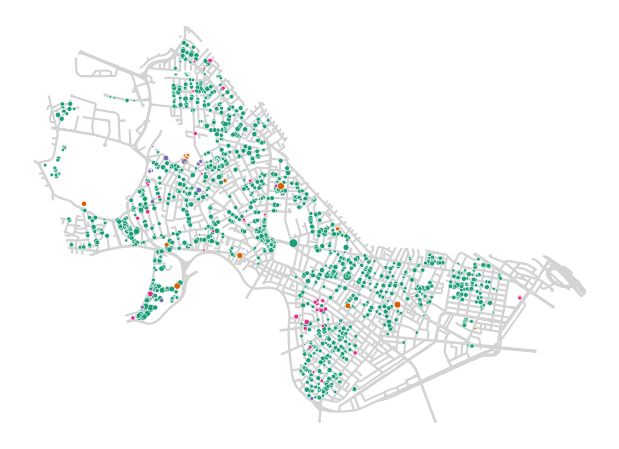

In [148]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect(1)

for shape in roads.shapes():
    points = np.array(shape.points)
    intervals = list(shape.parts) + [len(shape.points)]
    for (i, j) in zip(intervals[:-1], intervals[1:]):
        ax.plot(*zip(*points[i:j]), color="lightgray", zorder=0)
        ax.set_xticks([])
        ax.set_yticks([])

invasives = trees[trees["Invasive"]]

for label in invasives["Sci"].unique():
    ax.scatter(
        *transformer.transform(
            invasives[invasives["Sci"] == label]["lon"].to_list(),
            invasives[invasives["Sci"] == label]["lat"].to_list()
        ),
        label=label,
        #marker=".",
        edgecolor="w",
        linewidth=0.5,
        s = invasives[invasives["Sci"] == label]["diameter"]
    )

# plt.legend();
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-map-invasives.svg")

## Map neighborhoods

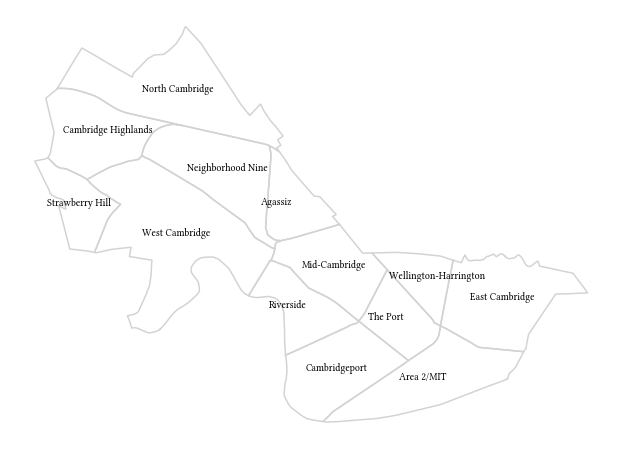

In [22]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_aspect(1)

for shape in neighborhoods.shapes():
    points = np.array(shape.points)
    intervals = list(shape.parts) + [len(shape.points)]
    for (i, j) in zip(intervals[:-1], intervals[1:]):
        ax.plot(*zip(*points[i:j]), color="lightgray", zorder=0)
        ax.set_xticks([])
        ax.set_yticks([])

for n in range(13):
    xy = transformer.transform(*polygons[n].centroid.coords[0])
    plt.text(xy[0] - 1500, xy[1], neigh_names[n])
    
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-map-neighborhoods.svg")

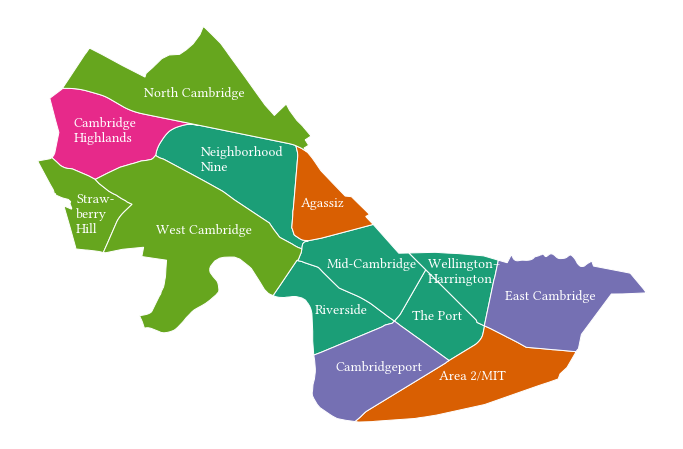

In [144]:
neigh_names = {
   -1: "(unknown)",
    0: "The Port",
    1: "Riverside",
    2: "Neighborhood\nNine",
    3: "Area 2/MIT",
    4: "Cambridgeport",
    5: "Mid-Cambridge",
    6: "Wellington–\nHarrington",
    7: "East Cambridge",
    8: "Agassiz",
    9: "Cambridge\nHighlands",
    10: "Straw-\nberry\nHill",
    11: "West Cambridge",
    12: "North Cambridge",
}

neigh_adjustments = {
    0:  (-1200, 0),
    1:  (-700, -300),
    2:  (-1700, 0),
    3:  (-1500, 0),
    4:  (-1500, 0),
    5:  (-1700, 0),
    6:  (-1500, -200),
    7:  (-2000, 0),
    8:  (-900, -100),
    9:  (-1300, -400),
    10: (-400, -1300),
    11: (-1500, 100),
    12: (-2000, -200),
}

fig, ax = plt.subplots(figsize=(12, 8))
#ax.set_aspect(1)

colors = {}
c = 0
for i, polygon in enumerate(polygons):
    most_popular = trees[trees["Neigh"]==i]["Sci"].value_counts().sort_values(ascending=False).index[0]
    
    # Assign each species a specific color.
    # Don't know if there's a more elegant way to achieve this...
    if not most_popular in colors:
        colors[most_popular] = c
        c += 1
    
    # Plot neighborhoods
    ax.fill(
        *transformer.transform(*polygon.exterior.xy),
        label=most_popular,
        facecolor=f"C{colors[most_popular]}",
        edgecolor="w",
    )
    
    # Plot neighborhood names
    xy = transformer.transform(*polygon.centroid.coords[0])
    plt.text(
        xy[0] + neigh_adjustments[i][0],
        xy[1] + neigh_adjustments[i][1],
        neigh_names[i], color="w", size=14)
    
ax.set_xticks([])
ax.set_yticks([])
#ax.legend();
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-map-neighborhoods.svg")

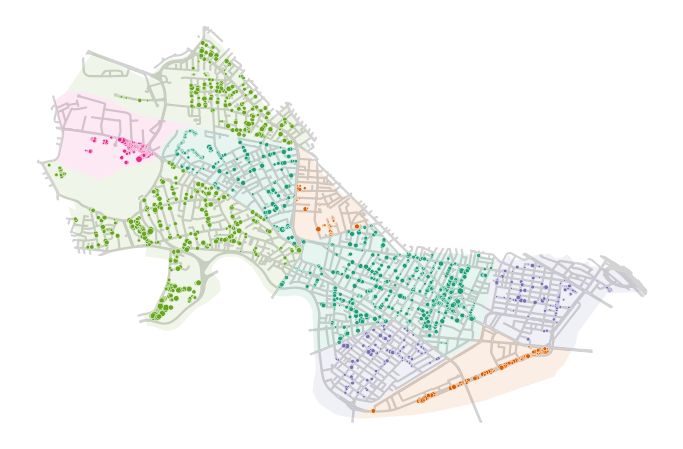

In [160]:
fig, ax = plt.subplots(figsize=(12, 8))
#ax.set_aspect(1)

# Plot roads
for shape in roads.shapes():
    points = np.array(shape.points)
    intervals = list(shape.parts) + [len(shape.points)]
    for (i, j) in zip(intervals[:-1], intervals[1:]):
        ax.plot(*zip(*points[i:j]), color="lightgray", zorder=0)
        ax.set_xticks([])
        ax.set_yticks([])

colors = {}
c = 0
for i, polygon in enumerate(polygons):
    most_popular = trees[trees["Neigh"]==i]["Sci"].value_counts().sort_values(ascending=False).index[0]
    
    # Assign each species a specific color.
    # Don't know if there's a more elegant way to achieve this...
    if not most_popular in colors:
        colors[most_popular] = c
        c += 1
    
    # Plot neighborhoods
#     ax.plot(
#         *transformer.transform(*polygon.exterior.xy),
#         color="#A0A0A0",
#     )
    
    ax.fill(
        *transformer.transform(*polygon.exterior.xy),
        label=most_popular,
        facecolor=f"C{colors[most_popular]}",
        edgecolor="w",
        alpha=0.1
    )
    

    
    # Plot neighborhood names
#     xy = transformer.transform(*polygon.centroid.coords[0])
#     plt.text(
#         xy[0] + neigh_adjustments[i][0],
#         xy[1] + neigh_adjustments[i][1],
#         neigh_names[i], color="w", size=14)
    
    popular = trees[
        (trees["Neigh"] == i) &
        (trees["Sci"] == most_popular)
    ]
    ax.scatter(
        *transformer.transform(
            popular["lon"].to_list(),
            popular["lat"].to_list()
        ),
        label=label,
        color=f"C{colors[most_popular]}",
        #marker=".",
        edgecolor="w",
        linewidth=0.5,
        s = popular["diameter"]
    )

# plt.legend();
    
ax.set_xticks([])
ax.set_yticks([])
#ax.legend();
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-map-neighborhoods-trees.svg")

# Plant date

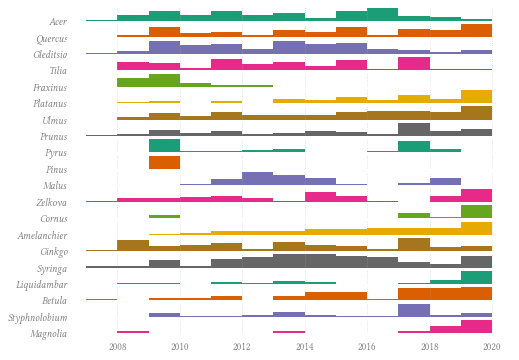

In [86]:
np.random.seed(seed)

genera = trees["Genus"].value_counts()[:20]
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "x"
plt.rcParams["axes.grid.which"] = "both"


i=0
fig, axes = plt.subplots(20, 1, figsize=(8, 6), sharex=True)
for genus, y, ax in zip(genera.index, genera.rank(), axes.ravel()):
    
    dates = trees[
        (trees["PlantDate"] > "2007") &
        (trees["Genus"] == genus)
    ]["PlantDate"].dt.year #.apply(lambda d: d + pd.DateOffset(days=np.random.normal(scale=7)))
    
#     ax.scatter(
#         dates,
#         [y-1] * len(dates), # + np.random.normal(scale=0.1, size=len(dates)),
#         marker=".",
#         edgecolor="w",
#         linewidth=0.5,
#         alpha=0.5
#     )

    ax.hist(dates, range(2007, 2021), color=f"C{i}", density=True)
#     dates.hist(ax=ax)
#     ax.set_yticks();
    ax.set_yticklabels([genus], fontdict={"style": "italic"});
    
    i += 1

plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-dates.svg")

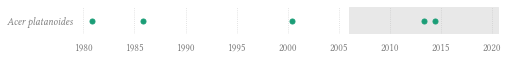

In [249]:
species = trees[trees["Invasive"]]["Sci"].value_counts()[::-1]

fig, ax = plt.subplots(figsize=(8, 0.5))
    
dates = trees[
    (trees["Sci"] == "Acer platanoides")
]["PlantDate"]

ax.axvspan(
    pd.to_datetime("2006-01-01"),
    pd.to_datetime("2020-07-21"),
    color="#e8e8e8",
    zorder=0
)

ax.scatter(
    dates,
    [0] * len(dates),
    marker=".",
    alpha=1
)

# ax.annotate(
#     "Made illegal",
#     (pd.to_datetime("2006-01-01"), 0),
# )

ax.set_yticks([0]);
ax.set_yticklabels(["Acer platanoides"], fontdict={"style": "italic"});

plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-dates-acer.svg")

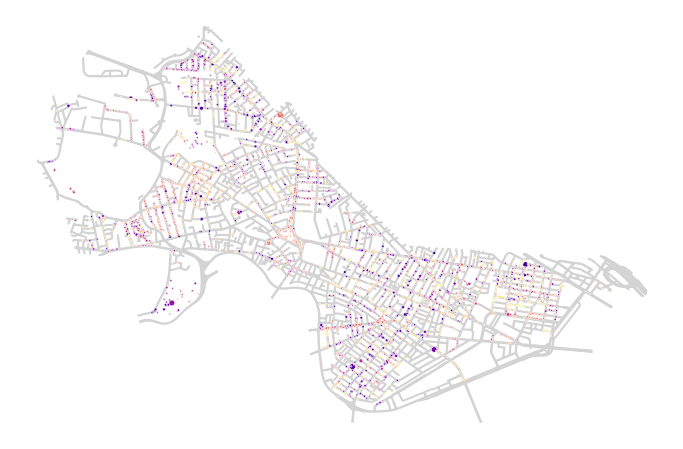

In [334]:
# Subset to map
dated = trees[trees["PlantDate"] > "2007"].copy()

epoch = int(pd.to_datetime("2007-01-01").strftime("%s"))
today = int(pd.to_datetime("2020-07-21").strftime("%s"))

dated["recency"] = (dated["PlantDate"].apply(lambda d: d.strftime("%s")).astype(int) - epoch) / (today - epoch)

fig, ax = plt.subplots(figsize=(12, 8))
#ax.set_aspect(1)

# Plot roads
for shape in roads.shapes():
    points = np.array(shape.points)
    intervals = list(shape.parts) + [len(shape.points)]
    for (i, j) in zip(intervals[:-1], intervals[1:]):
        ax.plot(*zip(*points[i:j]), color="lightgray", zorder=0)

# Plot trees
ax.scatter(
    *transformer.transform(
        dated["lon"].to_list(),
        dated["lat"].to_list()
    ),
    label = dated["PlantDate"].dt.year,
    edgecolor="w",
    linewidth=0.5,
    s = dated["diameter"],
    c = dated["PlantDate"],
    cmap = "plasma",
)

ax.set_xticks([])
ax.set_yticks([])
#plt.legend()
plt.savefig("/home/alex/Documents/Website/alexklapheke.github.io/blog/drafts/trees-map-dates.svg")

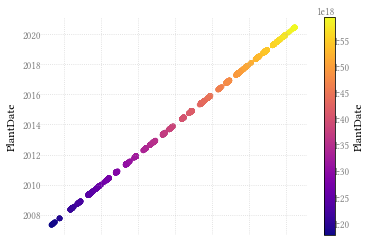

In [330]:
dated.plot.scatter("PlantDate", "PlantDate", c="PlantDate", cmap="plasma")
plt.savefig("/home/alex/Downloads/bar.svg")

# Modeling

In [351]:
date = trees[["diameter", "PlantDate"]].dropna()

date["date"] = date["PlantDate"].apply(lambda d: d.strftime("%s")).astype(int)

date.corr()

,diameter,date
diameter,1.000000,-0.634639
date,-0.634639,1.000000


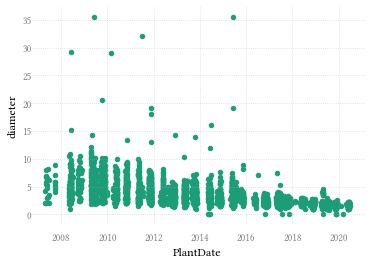

In [357]:
date[date["PlantDate"] > "2007"].plot.scatter("PlantDate", "diameter")

In [370]:
trees_model = trees[trees["PlantDate"].notna()]

X = pd.concat([
        trees_model[["diameter"]],
        pd.get_dummies(trees_model["Genus"]),
        pd.get_dummies(trees_model["Neigh_name"]),
        #pd.get_dummies(trees_model["area"], prefix="Area"),
        #pd.get_dummies(trees_model["Location"])
    ], axis=1)
y = trees_model["PlantDate"].astype(int)

#poly = PolynomialFeatures(include_bias=False, interaction_only=True).fit(X)
#X = pd.DataFrame(poly.transform(X), columns=poly.get_feature_names(X.columns))

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [371]:
from sklearn.linear_model import LassoCV

model = LassoCV(random_state=seed)
model.fit(X_train, y_train)
print("Train:", model.score(X_train, y_train))
print("Test:", model.score(X_test, y_test))

Train: 0.503631846534224
Test: 0.5232940004966089


In [372]:
coefs = pd.Series(model.coef_, index=X.columns)
coefs = coefs[coefs != 0]

In [373]:
coefs

diameter                -3.406596e+16
Acer                    -4.933641e+16
Carpinus                 9.832552e+13
Celtis                  -2.930692e+15
Eucommia                 1.092500e+16
Fraxinus                -3.946113e+17
Ginkgo                  -5.365303e+16
Gleditsia               -4.794647e+16
Gymnocladus              4.512861e+16
Koelreuteria            -7.054940e+16
Liquidambar              1.824068e+16
Liriodendron             3.447928e+16
Malus                   -3.695042e+16
Metasequoia              5.078665e+16
Ostrya                   1.135387e+16
Platanus                 2.206802e+16
Prunus                  -9.363582e+15
Pyrus                   -3.951640e+16
Quercus                 -6.670209e+15
Syringa                 -4.864239e+16
Tilia                   -4.409495e+16
Ulmus                    1.011446e+16
(unknown)               -1.248569e+16
Agassiz                 -1.489991e+16
Cambridge Highlands     -3.428300e+16
Cambridgeport           -7.384461e+15
East Cambrid

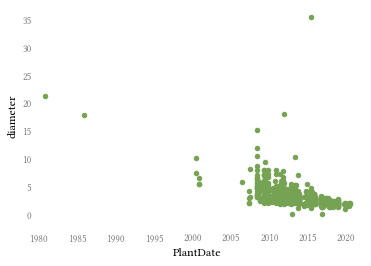

In [99]:
trees[trees["Genus"] == "Acer"].plot.scatter("PlantDate", "diameter")

In [120]:
trees.sort_values("diameter", ascending=False)[["lat", "lon", "Genus", "PlantDate", "diameter"]].head(20)

,lat,lon,Genus,PlantDate,diameter
29029,-71.115165,42.375683,Acer,NaT,945.00
13707,-71.086207,42.366062,Platanus,NaT,915.00
12283,-71.082596,42.365017,Ulmus,NaT,745.00
14864,-71.103449,42.370909,Prunus,NaT,715.00
6822,-71.105605,42.371266,Acer,NaT,154.00
5146,-71.112739,42.374116,Koelreuteria,NaT,86.00
17300,-71.100504,42.360388,Quercus,NaT,75.00
13364,-71.082929,42.364470,Gymnocladus,NaT,74.00
8284,-71.139207,42.367670,Fraxinus,NaT,72.00
20244,-71.079809,42.370264,Malus,NaT,71.00


Text(0.5, 1.0, '')

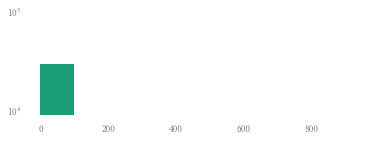

In [207]:
plt.rcParams["font.style"] = "normal"

trees.hist("diameter", log=True, figsize=(6, 2), bins=range(0, 1000, 100), grid=False)
plt.title("")